In [1]:
# Importing necessary modules
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Importing functions from functions.py. This gets them from GitHub.

!wget -O functions.py https://raw.githubusercontent.com/up941791/ACT_2/main/py/functions.py
import functions as fn

--2026-01-05 13:43:42--  https://raw.githubusercontent.com/up941791/ACT_2/main/py/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143 [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]     143  --.-KB/s    in 0s      

2026-01-05 13:43:42 (4.42 MB/s) - ‘functions.py’ saved [143/143]



In [3]:
# Downloading the dataset

os.environ['KAGGLE_USERNAME'] = 'samhedley'
os.environ['KAGGLE_KEY'] = 'KGAT_b7cd8b87cb2a0346ef10f-b182f099721'
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria --unzip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 98% 662M/675M [00:01<00:00, 278MB/s] 
100% 675M/675M [00:02<00:00, 354MB/s]


In [4]:
data_dir = "./cell_images" # Directory for the dataset

In [5]:
# Function to split dataset paths into training, validation, and test set paths
def split_dataset_paths(folder_path, test_size, val_size):

    split_paths = {'train': [], 'val': [], 'test': []}

    for label in ['Parasitized', 'Uninfected']: # Looping through both classes
        imgs = [] # List to hold valid image paths
        class_dir = os.path.join(folder_path, label) # Directory for the current class
        for img_name in os.listdir(class_dir): # Looping through images in the class directory
            img_path = os.path.join(class_dir, img_name) # Full path to the image
            
            imgs.append((img_path, label)) # Append image path and label

        train_imgs, temp_imgs = train_test_split(imgs, test_size=test_size + val_size, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_size / (test_size + val_size), random_state=42)

        split_paths['train'].extend(train_imgs)
        split_paths['val'].extend(val_imgs)
        split_paths['test'].extend(test_imgs)

    return split_paths

In [6]:
# Splitting dataset into train, val, and test sets
split_paths = split_dataset_paths(data_dir, test_size=0.15, val_size=0.15) 

In [7]:
# Checking the number of samples in each split
print("Training samples:", len(split_paths['train']))
print("Validation samples:", len(split_paths['val']))
print("Test samples:", len(split_paths['test']))

Training samples: 19292
Validation samples: 4134
Test samples: 4134


In [8]:
# Creating dataframes for each split
train_df = fn.make_dataframe(split_paths, 'train')
val_df = fn.make_dataframe(split_paths, 'val')
test_df = fn.make_dataframe(split_paths, 'test')

In [9]:
# Setting up ImageDataGenerators for training, validation, and test sets

target_size = (128, 128) # Target size for image resizing
batch_size = 64 # Batch size for training and validation

datagen = ImageDataGenerator(rescale=1./255) # Scaling pixel values to [0, 1]

train_gen = datagen.flow_from_dataframe( # Training data generator
    train_df,
    x_col='img_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = datagen.flow_from_dataframe( # Validation data generator
    val_df,
    x_col='img_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = datagen.flow_from_dataframe( # Test data generator
    test_df,
    x_col='img_path',
    y_col='label',
    target_size=target_size,
    batch_size=1,
    class_mode='binary'
)

Found 19290 validated image filenames belonging to 2 classes.
Found 4134 validated image filenames belonging to 2 classes.
Found 4134 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [10]:
# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [11]:
# Setting up learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

In [12]:
# Setting up early stopping to stop if the model stops improving
earlystopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=False
)

In [13]:
# List of callbacks to be used during training
callbacks_list = [checkpoint, reduce_lr, earlystopping]

In [14]:
# Building the CNN model

cNN = Sequential()

cNN.add(Input(shape=(128, 128, 3)))
cNN.add(Conv2D(32, (3, 3), activation='relu'))
cNN.add(MaxPooling2D((2, 2)))
cNN.add(Conv2D(64, (3, 3), activation='relu'))
cNN.add(MaxPooling2D((2, 2)))
cNN.add(Conv2D(128, (3, 3), activation='relu'))
cNN.add(MaxPooling2D((2, 2)))

cNN.add(Flatten())
cNN.add(Dense(64, activation='relu'))
cNN.add(Dropout(0.5))

cNN.add(Dense(1, activation='sigmoid'))

In [15]:
optimiser = Adam(learning_rate=0.001) # Setting the optimiser

cNN.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [16]:
# Training the model
model1 = cNN.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6402 - loss: 0.6391 - precision: 0.7031 - recall: 0.4593
Epoch 1: val_accuracy improved from -inf to 0.93299, saving model to best_model.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.6406 - loss: 0.6388 - precision: 0.7034 - recall: 0.4601 - val_accuracy: 0.9330 - val_loss: 0.3395 - val_precision: 0.9167 - val_recall: 0.9526 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9237 - loss: 0.2930 - precision: 0.8936 - recall: 0.9621
Epoch 2: val_accuracy improved from 0.93299 to 0.94727, saving model to best_model.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9237 - loss: 0.2929 - precision: 0.8937 - recall: 0.9621 - val_accuracy: 0.9473 - val_loss: 0.1828 - val_precision: 0.9212 - val_recall: 0.9782 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9509 - loss: 0.2088 - precision: 0.9351 - recall: 0.9689
Epoch 3: val_

In [17]:
# Testing the model on the test set

cNN.load_weights('best_model.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4134/4134 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9621 - loss: 0.1350 - precision: 0.9475 - recall: 0.9780
Test Accuracy: 0.9589
Test loss: 0.1425
Test Recall: 0.9744
Test Precision: 0.9451


In [18]:
cNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,097,029 (19.44 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,398,020 (12.96 MB)

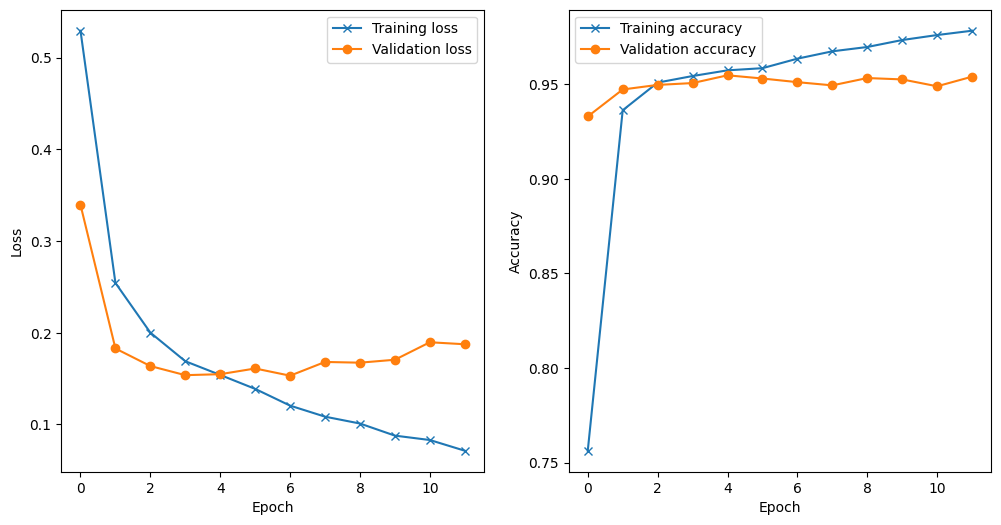

In [19]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(model1.history['loss'], 'x-', label="Training loss")
plt.plot(model1.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model1.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(model1.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

2 Conv layers (removed 128 filter layer and corresponding maxpooling)

In [20]:
# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_2.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# List of callbacks to be used during training
callbacks_list_2 = [checkpoint, reduce_lr, earlystopping]

# Building the CNN model

cNN2 = Sequential()

cNN2.add(Input(shape=(128, 128, 3)))
cNN2.add(Conv2D(32, (3, 3), activation='relu'))
cNN2.add(MaxPooling2D((2, 2)))
cNN2.add(Conv2D(64, (3, 3), activation='relu'))
cNN2.add(MaxPooling2D((2, 2)))

cNN2.add(Flatten())
cNN2.add(Dense(64, activation='relu'))
cNN2.add(Dropout(0.5))

cNN2.add(Dense(1, activation='sigmoid'))


optimiser = Adam(learning_rate=0.001) # Setting the optimiser
cNN2.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [21]:
# Training the model
model2 = cNN2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list_2
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5756 - loss: 0.7513 - precision_1: 0.5745 - recall_1: 0.6161
Epoch 1: val_accuracy improved from -inf to 0.77238, saving model to best_model_2.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - accuracy: 0.5758 - loss: 0.7510 - precision_1: 0.5747 - recall_1: 0.6161 - val_accuracy: 0.7724 - val_loss: 0.5093 - val_precision_1: 0.7534 - val_recall_1: 0.8099 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8486 - loss: 0.3998 - precision_1: 0.8407 - recall_1: 0.8622
Epoch 2: val_accuracy improved from 0.77238 to 0.92598, saving model to best_model_2.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.8487 - loss: 0.3996 - precision_1: 0.8408 - recall_1: 0.8622 - val_accuracy: 0.9260 - val_loss: 0.2151 - val_precision_1: 0.9239 - val_recall_1: 0.9284 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9235 - loss: 0.2180 - precision

In [22]:
# Testing the model on the test set

cNN2.load_weights('best_model_2.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN2.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4134/4134 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9350 - loss: 0.2837 - precision_1: 0.9313 - recall_1: 0.9377
Test Accuracy: 0.9349
Test loss: 0.2753
Test Recall: 0.9386
Test Precision: 0.9318


In [23]:
cNN2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,117,765 (42.41 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,411,844 (28.27 MB)

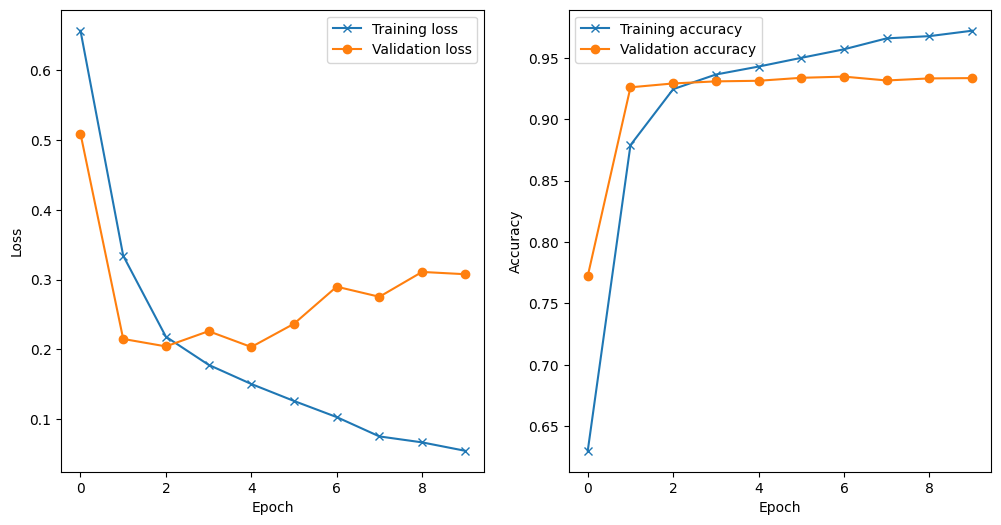

In [24]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(model2.history['loss'], 'x-', label="Training loss")
plt.plot(model2.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model2.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(model2.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

3 Conv layers - less filters (8/16/32)

In [25]:
# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_3.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# List of callbacks to be used during training
callbacks_list_3 = [checkpoint, reduce_lr, earlystopping]

# Building the CNN model

cNN3 = Sequential()

cNN3.add(Input(shape=(128, 128, 3)))
cNN3.add(Conv2D(8, (3, 3), activation='relu'))
cNN3.add(MaxPooling2D((2, 2)))
cNN3.add(Conv2D(16, (3, 3), activation='relu'))
cNN3.add(MaxPooling2D((2, 2)))
cNN3.add(Conv2D(32, (3, 3), activation='relu'))
cNN3.add(MaxPooling2D((2, 2)))

cNN3.add(Flatten())
cNN3.add(Dense(64, activation='relu'))
cNN3.add(Dropout(0.5))
cNN3.add(Dense(1, activation='sigmoid'))


optimiser = Adam(learning_rate=0.001) # Setting the optimiser
cNN3.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [26]:
# Training the model
model3 = cNN3.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list_3
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5979 - loss: 0.6561 - precision_2: 0.6006 - recall_2: 0.6044
Epoch 1: val_accuracy improved from -inf to 0.90590, saving model to best_model_3.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 42s 123ms/step - accuracy: 0.5982 - loss: 0.6558 - precision_2: 0.6009 - recall_2: 0.6047 - val_accuracy: 0.9059 - val_loss: 0.2683 - val_precision_2: 0.9329 - val_recall_2: 0.8747 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9169 - loss: 0.2445 - precision_2: 0.9337 - recall_2: 0.8965
Epoch 2: val_accuracy improved from 0.90590 to 0.92743, saving model to best_model_3.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.9170 - loss: 0.2444 - precision_2: 0.9337 - recall_2: 0.8966 - val_accuracy: 0.9274 - val_loss: 0.1891 - val_precision_2: 0.9533 - val_recall_2: 0.8989 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9325 - loss: 0.1967 - precision

In [27]:
# Testing the model on the test set

cNN3.load_weights('best_model_3.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN3.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4134/4134 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9507 - loss: 0.1777 - precision_2: 0.9383 - recall_2: 0.9633
Test Accuracy: 0.9521
Test loss: 0.1657
Test Recall: 0.9647
Test Precision: 0.9410


In [28]:
cNN3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,222,709 (4.66 MB)

 Trainable params: 407,569 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 815,140 (3.11 MB)

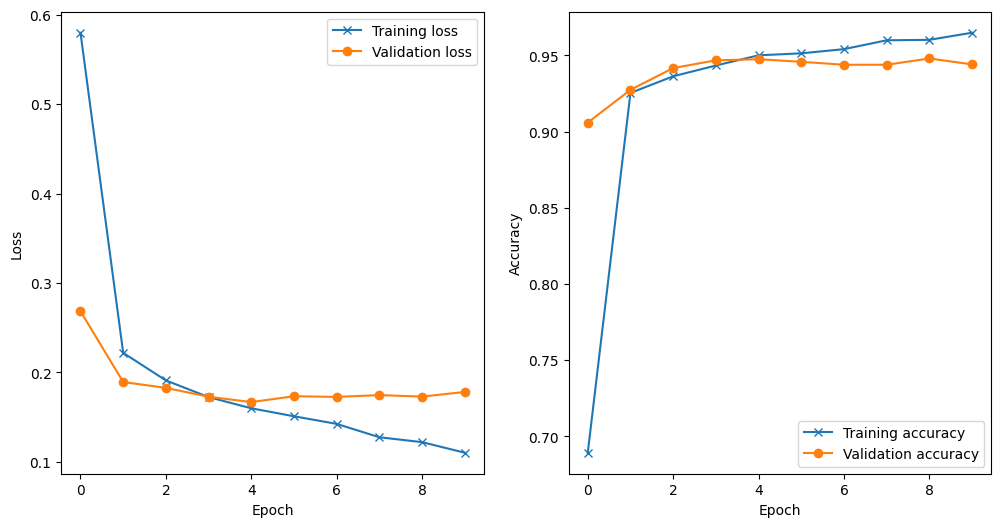

In [29]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(model3.history['loss'], 'x-', label="Training loss")
plt.plot(model3.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model3.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(model3.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

3 Conv layers - even less filters (2/4/8)

In [30]:
# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_4.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# List of callbacks to be used during training
callbacks_list_4 = [checkpoint, reduce_lr, earlystopping]

# Building the CNN model

cNN4 = Sequential()
cNN4.add(Input(shape=(128, 128, 3)))
cNN4.add(Conv2D(2, (3, 3), activation='relu'))
cNN4.add(MaxPooling2D((2, 2)))
cNN4.add(Conv2D(4, (3, 3), activation='relu'))
cNN4.add(MaxPooling2D((2, 2)))
cNN4.add(Conv2D(8, (3, 3), activation='relu'))
cNN4.add(MaxPooling2D((2, 2)))

cNN4.add(Flatten())
cNN4.add(Dense(64, activation='relu'))
cNN4.add(Dropout(0.5))
cNN4.add(Dense(1, activation='sigmoid'))


optimiser = Adam(learning_rate=0.001) # Setting the optimiser
cNN4.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [31]:
# Training the model
model4 = cNN4.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list_4
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6340 - loss: 0.6278 - precision_3: 0.6404 - recall_3: 0.5882
Epoch 1: val_accuracy improved from -inf to 0.77625, saving model to best_model_4.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 33s 95ms/step - accuracy: 0.6342 - loss: 0.6276 - precision_3: 0.6407 - recall_3: 0.5884 - val_accuracy: 0.7762 - val_loss: 0.4538 - val_precision_3: 0.8547 - val_recall_3: 0.6657 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8293 - loss: 0.3765 - precision_3: 0.8384 - recall_3: 0.8144
Epoch 2: val_accuracy improved from 0.77625 to 0.92090, saving model to best_model_4.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.8294 - loss: 0.3763 - precision_3: 0.8385 - recall_3: 0.8146 - val_accuracy: 0.9209 - val_loss: 0.2234 - val_precision_3: 0.9311 - val_recall_3: 0.9090 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9290 - loss: 0.1958 - precision_

In [32]:
# Testing the model on the test set

cNN4.load_weights('best_model_4.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN4.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4134/4134 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9543 - loss: 0.1547 - precision_3: 0.9527 - recall_3: 0.9564
Test Accuracy: 0.9543
Test loss: 0.1586
Test Recall: 0.9589
Test Precision: 0.9501


In [33]:
cNN4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,729 (1.15 MB)

 Trainable params: 100,909 (394.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 201,820 (788.36 KB)

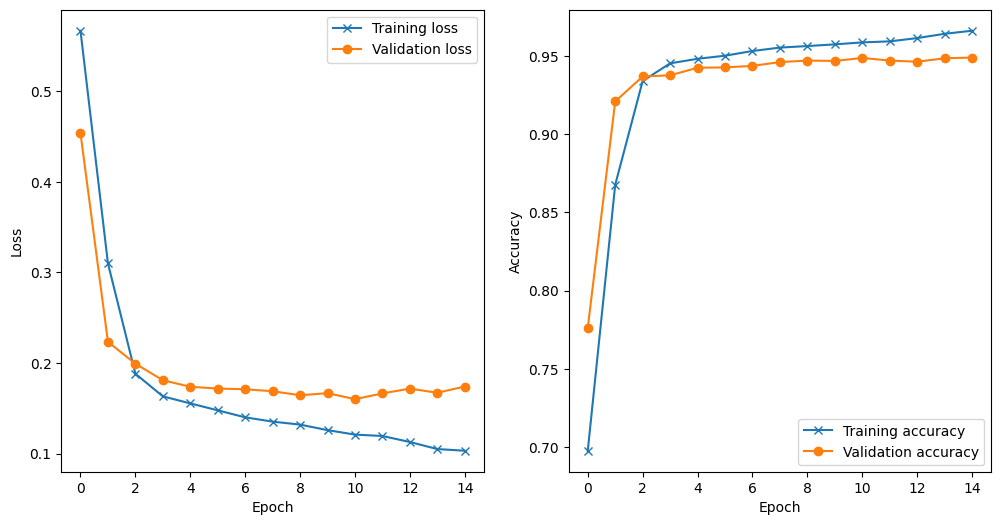

In [34]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(model4.history['loss'], 'x-', label="Training loss")
plt.plot(model4.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model4.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(model4.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

Increasing kernel size - 5x5

In [35]:
# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_5.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# List of callbacks to be used during training
callbacks_list_5 = [checkpoint, reduce_lr, earlystopping]

# Building the CNN model

cNN5 = Sequential()

cNN5.add(Input(shape=(128, 128, 3)))
cNN5.add(Conv2D(32, (5, 5), activation='relu'))
cNN5.add(MaxPooling2D((2, 2)))
cNN5.add(Conv2D(64, (5, 5), activation='relu'))
cNN5.add(MaxPooling2D((2, 2)))
cNN5.add(Conv2D(128, (5, 5), activation='relu'))
cNN5.add(MaxPooling2D((2, 2)))

cNN5.add(Flatten())
cNN5.add(Dense(64, activation='relu'))
cNN5.add(Dropout(0.5))
cNN5.add(Dense(1, activation='sigmoid'))


optimiser = Adam(learning_rate=0.001) # Setting the optimiser
cNN5.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [36]:
# Training the model
model5 = cNN5.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list_5
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5894 - loss: 0.6624 - precision_4: 0.5848 - recall_4: 0.6306
Epoch 1: val_accuracy improved from -inf to 0.91582, saving model to best_model_5.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.5898 - loss: 0.6620 - precision_4: 0.5851 - recall_4: 0.6309 - val_accuracy: 0.9158 - val_loss: 0.2934 - val_precision_4: 0.9451 - val_recall_4: 0.8829 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9264 - loss: 0.2273 - precision_4: 0.9278 - recall_4: 0.9247
Epoch 2: val_accuracy improved from 0.91582 to 0.93977, saving model to best_model_5.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.9264 - loss: 0.2272 - precision_4: 0.9278 - recall_4: 0.9247 - val_accuracy: 0.9398 - val_loss: 0.1731 - val_precision_4: 0.9316 - val_recall_4: 0.9492 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9433 - loss: 0.1722 - precision

In [37]:
# Testing the model on the test set

cNN5.load_weights('best_model_5.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN5.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4134/4134 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9601 - loss: 0.1380 - precision_4: 0.9545 - recall_4: 0.9671
Test Accuracy: 0.9611
Test loss: 0.1353
Test Recall: 0.9710
Test Precision: 0.9521


In [38]:
cNN5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 58, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 25, 25, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,315,205 (16.46 MB)

 Trainable params: 1,438,401 (5.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,876,804 (10.97 MB)

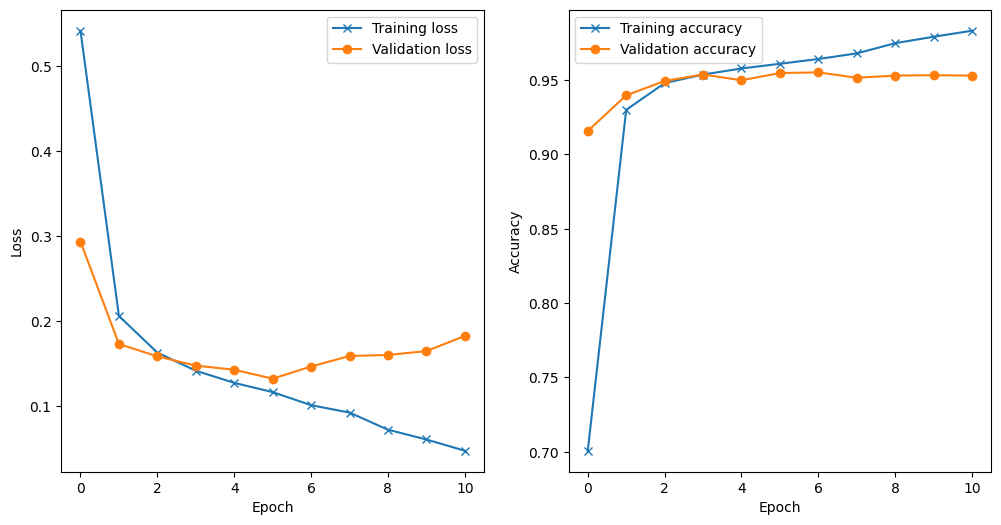

In [39]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(model5.history['loss'], 'x-', label="Training loss")
plt.plot(model5.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model5.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(model5.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

No MaxPooling 

In [40]:
# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_6.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# List of callbacks to be used during training
callbacks_list_6 = [checkpoint, reduce_lr, earlystopping]

# Building the CNN model

cNN6 = Sequential()

cNN6.add(Input(shape=(128, 128, 3)))
cNN6.add(Conv2D(32, (3, 3), activation='relu'))
cNN6.add(Conv2D(64, (3, 3), activation='relu'))
cNN6.add(Conv2D(128, (3, 3), activation='relu'))

cNN6.add(Flatten())
cNN6.add(Dense(64, activation='relu'))
cNN6.add(Dropout(0.5))
cNN6.add(Dense(1, activation='sigmoid'))


optimiser = Adam(learning_rate=0.001) # Setting the optimiser
cNN6.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [41]:
# Training the model
model6 = cNN6.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list_6
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5556 - loss: 2.7679 - precision_5: 0.5508 - recall_5: 0.6211
Epoch 1: val_accuracy improved from -inf to 0.56096, saving model to best_model_6.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 147s 426ms/step - accuracy: 0.5558 - loss: 2.7622 - precision_5: 0.5510 - recall_5: 0.6214 - val_accuracy: 0.5610 - val_loss: 0.6774 - val_precision_5: 0.5372 - val_recall_5: 0.8795 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6622 - loss: 0.5969 - precision_5: 0.6404 - recall_5: 0.7480
Epoch 2: val_accuracy improved from 0.56096 to 0.59361, saving model to best_model_6.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 157s 521ms/step - accuracy: 0.6621 - loss: 0.5970 - precision_5: 0.6404 - recall_5: 0.7477 - val_accuracy: 0.5936 - val_loss: 0.6652 - val_precision_5: 0.5989 - val_recall_5: 0.5670 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6477 - loss: 0.6293 - pre

In [42]:
# Testing the model on the test set

cNN6.load_weights('best_model_6.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN6.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4134/4134 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.6405 - loss: 0.6429 - precision_5: 0.6745 - recall_5: 0.5637
Test Accuracy: 0.6396
Test loss: 0.6394
Test Recall: 0.5583
Test Precision: 0.6667


In [43]:
cNN6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 122, 122, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1905152)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │   121,929,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,069,317 (1.36 GB)

 Trainable params: 122,023,105 (465.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,046,212 (930.96 MB)

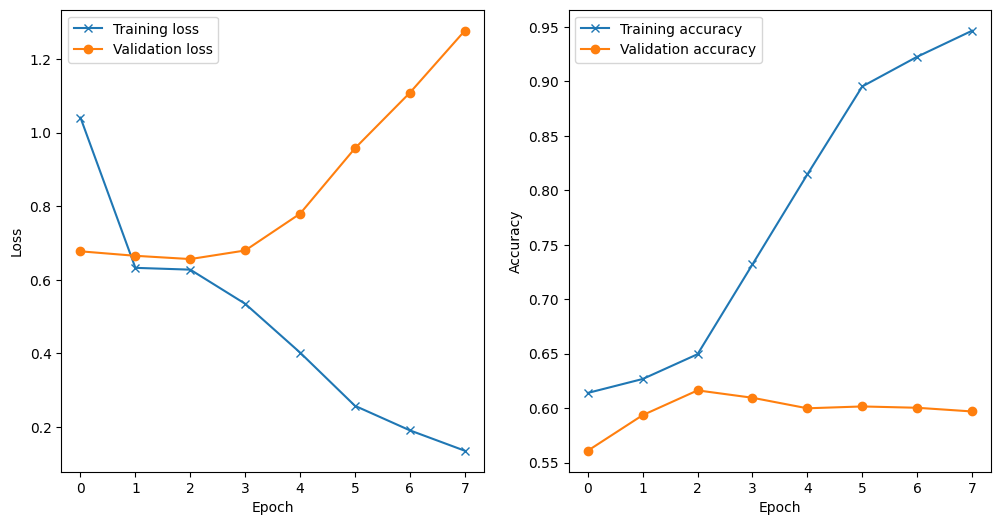

In [44]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(model6.history['loss'], 'x-', label="Training loss")
plt.plot(model6.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model6.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(model6.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()